In [3]:
import PIL
from PIL import ImageFilter
from PIL import Image

In [18]:
import numpy as np

In [8]:
import os

In [10]:
img_path = 'notebooks/images/input_img.jpg'
_, im_name = os.path.split(img_path)
mask_img = os.path.join('notebooks/images/mask', f'{im_name}')

In [12]:
mask_img

'notebooks/images/mask\\input_img.jpg'

In [13]:
orig_img = Image.open(img_path).convert('RGB')
width, height = orig_img.size
imask = Image.open(mask_img).convert('L').resize((width, height))

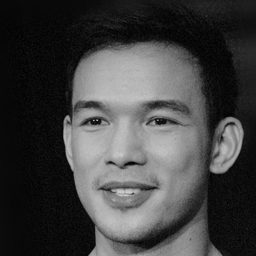

In [15]:
imask.resize((256, 256))

In [16]:
imask_gauss = imask.filter(ImageFilter.GaussianBlur(8))

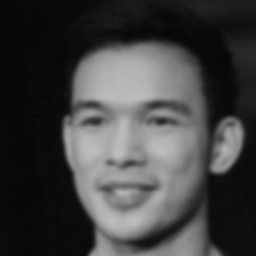

In [17]:
imask_gauss.resize((256, 256))

In [19]:
mask = np.array(imask_gauss)/255

In [22]:
np.min(mask)

0.0196078431372549

In [1]:
from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

# sys.path.append(".")
# sys.path.append("..")

from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

# %load_ext autoreload
# %autoreload 2

## Step 1: Select Experiment Type

In [2]:
#@title Select which experiment you wish to perform inference on: { run: "auto" }
experiment_type = 'ffhq_encode' #@param ['ffhq_encode', 'ffhq_frontalize', 'celebs_sketch_to_face', 'celebs_seg_to_face', 'celebs_super_resolution', 'toonify']

## Step 3: Define Inference Parameters

Below we have a dictionary defining parameters such as the path to the pretrained model to use and the path to the image to perform inference on.  
While we provide default values to run this script, feel free to change as needed.

In [3]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/psp_ffhq_encode.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
    "ffhq_frontalize": {
        "model_path": "pretrained_models/psp_ffhq_frontalization.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
    "celebs_sketch_to_face": {
        "model_path": "pretrained_models/psp_celebs_sketch_to_face.pt",
        "image_path": "notebooks/images/input_sketch.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()])
    },
    "celebs_seg_to_face": {
        "model_path": "pretrained_models/psp_celebs_seg_to_face.pt",
        "image_path": "notebooks/images/input_mask.png",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            augmentations.ToOneHot(n_classes=19),
            transforms.ToTensor()])
    },
    "celebs_super_resolution": {
        "model_path": "pretrained_models/psp_celebs_super_resolution.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            augmentations.BilinearResize(factors=[16]),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
    "toonify": {
        "model_path": "pretrained_models/psp_ffhq_toonify.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
}

In [4]:
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

We need to verify that the model was downloaded correctly. All of our models should weigh approximately 1.12GB.  
Note that if the file weighs several KBs, you most likely encounter a "quota exceeded" error from Google Drive. In that case, you should try downloading the model again after a few hours.

In [6]:
import os

In [7]:
if os.path.getsize(EXPERIMENT_ARGS['model_path']) < 1000000:
  raise ValueError("Pretrained model was unable to be downlaoded correctly!")

## Step 4: Load Pretrained Model
We assume that you have downloaded all relevant models and placed them in the directory defined by the above dictionary.

In [8]:
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')

In [9]:
opts = ckpt['opts']
pprint.pprint(opts)

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': None,
 'dataset_type': 'ffhq_encode',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 0,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 300000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 1000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0,
 'workers': 8}


In [10]:
# update the training options
opts['checkpoint_path'] = model_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024

In [11]:
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


## Step 5: Visualize Input

In [23]:
EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]

'notebooks/images/input_img.jpg'

In [32]:
# image_path = EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]
image_path = 'notebooks/images/j1.jpg'
original_image = Image.open(image_path)
if opts.label_nc == 0:
    original_image = original_image.convert("RGB")
else:
    original_image = original_image.convert("L")

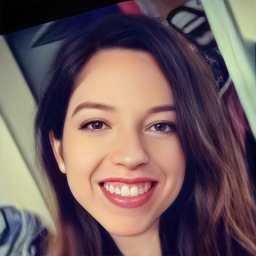

In [33]:
original_image.resize((256, 256))

### Align Image

Note: in this notebook we'll run alignment on the input image for all tasks except for `celebs_sketch_to_face` and `celebs_seg_to_face`. That is, only for tasks with real images as inputs.
However, all of our applications assume the input has been pre-aligned!

In [ ]:
def run_alignment(image_path):
  import dlib
  from scripts.align_all_parallel import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor)
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image

In [ ]:
if experiment_type not in ["celebs_sketch_to_face", "celebs_seg_to_face"]:
  input_image = run_alignment(image_path)
else:
  input_image = original_image

In [ ]:
input_image.resize((256, 256))

## Step 6: Perform Inference

In [34]:
input_image = original_image

In [35]:
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

In [16]:
def run_on_batch(inputs, net, latent_mask=None):
    if latent_mask is None:
        result_batch = net(inputs.to("cuda").float(), randomize_noise=False)
    else:
        result_batch = []
        for image_idx, input_image in enumerate(inputs):
            # get latent vector to inject into our input image
            vec_to_inject = np.random.randn(1, 512).astype('float32')
            _, latent_to_inject = net(torch.from_numpy(vec_to_inject).to("cuda"),
                                      input_code=True,
                                      return_latents=True)
            # get output image with injected style vector
            res = net(input_image.unsqueeze(0).to("cuda").float(),
                      latent_mask=latent_mask,
                      inject_latent=latent_to_inject)
            result_batch.append(res)
        result_batch = torch.cat(result_batch, dim=0)
    return result_batch

Optionally add a latent mask for inference.   
This is typically done only for conditional image synthesis (i.e. face from sketch and face from segmentation map). To disable the use of the latent mask, set `latent_mask = None` in the cell below.  

Feel free to change the cell below to see how the `latent_mask` affects the output image.

In [17]:
if experiment_type in ["celebs_sketch_to_face", "celebs_seg_to_face"]:
    latent_mask = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
else:
    latent_mask = None

In [36]:
with torch.no_grad():
    tic = time.time()
    result_image = run_on_batch(transformed_image.unsqueeze(0), net, latent_mask)[0]
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Inference took 0.4923 seconds.


### Visualize Result

In [37]:
input_vis_image = log_input_image(transformed_image, opts)
output_image = tensor2im(result_image)

In [38]:
if experiment_type == "celebs_super_resolution":
    res = np.concatenate([np.array(input_image.resize((256, 256))),
                          np.array(input_vis_image.resize((256, 256))),
                          np.array(output_image.resize((256, 256)))], axis=1)
else:
    res = np.concatenate([np.array(input_vis_image.resize((256, 256))),
                          np.array(output_image.resize((256, 256)))], axis=1)

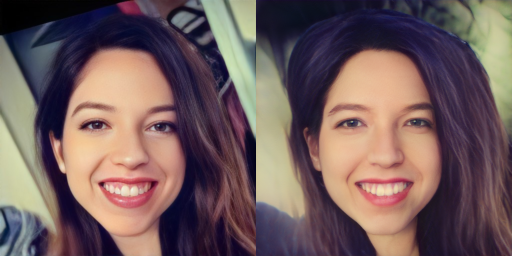

In [39]:
res_image = Image.fromarray(res)
res_image